# Code for the implementation of task MNist

### importing libraries

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import distance
from keras.datasets import mnist
import time

2023-04-27 19:27:49.254009: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 19:27:49.313803: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 19:27:49.545138: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 19:27:49.547146: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 19:27:50.512669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
class Dataset:
    def __init__(self, train_X, train_y, test_X, test_y):
        data = {"training": {"targets": [], "features":[]}, "testing": {"targets": [], "features":[]}}
                    
        data["training"]["features"] = train_X
        data["training"]["targets"] = train_y
        data["testing"]["features"] = test_X
        data["testing"]["targets"]  = test_y
        
        self.data = data
        self.DESCR = "MNISK dataset"
        self.n_training = 60000
        self.n_testing = 10000
        self.chunk_size = 1000
        self.n_chunks = self.n_training//self.chunk_size
        self.classes_names = ['0','1','2','3','4','5','6','7','8','9']


In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1] * train_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1] * test_X.shape[2]))
MNISK_Dataset = Dataset(train_X, train_y, test_X, test_y)


In [4]:
def NN_predict(images_predict, n_chunks, chunk_size, train_set):
    predicted = []
    time_s = time.time()
    for image in images_predict:
        min_dict = {"indices": [], "values": []}
        for i in range(n_chunks):
            reduced_test_set = train_set["features"][i*chunk_size:(i+1)*chunk_size]
            distances = np.ravel(distance.cdist([image], reduced_test_set, 'euclidean'))
            min_cluster_index = np.argmin(distances)
            min_global_index = i*chunk_size+min_cluster_index
            min_dict["indices"].append(min_global_index)
            min_dict["values"].append(distances[min_cluster_index])
        min_dict_NN_index = np.argmin(min_dict["values"])
        NN_global_index = min_dict["indices"][min_dict_NN_index]
        predicted.append(train_set["targets"][NN_global_index])
    print(f"time for Predicting: {time.time()-time_s}")
    return predicted

## Confusion matrix for test set

In [5]:
def PlotConfusionMatrix(matrix, fileName: str):
    fig, ax = plt.subplots(figsize=(8, 8))
    metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, 
                                   display_labels=MNISK_Dataset.classes_names,
                                   ).plot(cmap="viridis", ax=ax)
    plt.title("NN classifier", fontsize=18)
    plt.tight_layout()
    plt.suptitle(f"{fileName}", fontsize=18, x=0.1)
    plt.savefig(f"svg_figures/{fileName}.svg")
    plt.show()

In [6]:
def conf_matrix_test(MNISK_Dataset: Dataset):
    n_classes = 10
    data = MNISK_Dataset.data
    conf_matrix = np.zeros((n_classes, n_classes)).astype(int)
    testing_data = data["testing"]["features"]
    prediction = NN_predict(testing_data, MNISK_Dataset.n_chunks, MNISK_Dataset.chunk_size, data["training"])
    n_misclassified = 0
    misclassified_examples = []
    correctly_classified_examples = []
    for i in range(len(prediction)):
        target = data["testing"]["targets"][i]
        pred = prediction[i]
        conf_matrix[target, pred] += 1 
        if target != pred and len(misclassified_examples) < 4:
            n_misclassified += 1
            misclassified_examples.append([testing_data[i], pred, target])
        elif target == pred and len(correctly_classified_examples) < 4:
            correctly_classified_examples.append([testing_data[i], pred, target])


    error_rate = n_misclassified / len(testing_data)
    return conf_matrix, error_rate, misclassified_examples, correctly_classified_examples 

In [7]:
confusion_matrix, error_rate, misclassified_examples, correctly_classified_examples = conf_matrix_test(MNISK_Dataset)

time for Predicting: 458.3147053718567


Error rate: 0.0004


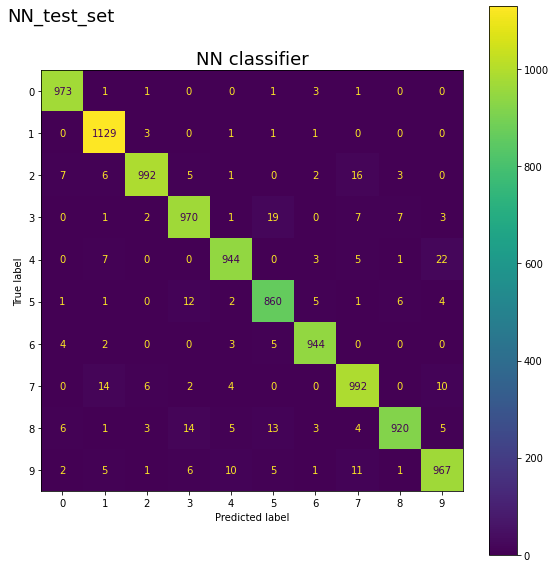

In [8]:
print("Error rate: " + str(error_rate))
PlotConfusionMatrix(confusion_matrix, "NN_test_set")

## 1b) Plot some examples

In [9]:
def PlotExamples(examples, fileName: str):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for i, (image, predicted, target) in enumerate(examples):
        ax = axs[i//2, i%2]
        ax.set_title(f"Classified as {predicted}, target is {target}", fontsize=18)
        ax.imshow(np.reshape(image, (28, 28)), cmap='cividis')

    fig.subplots_adjust(hspace=0.4)
    plt.savefig(f"svg_figures/{fileName}.svg")
    plt.show()

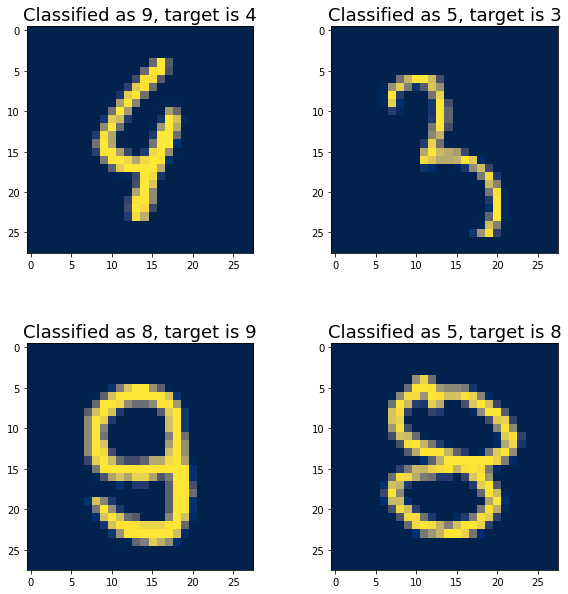

In [10]:
PlotExamples(misclassified_examples, "misclassified")


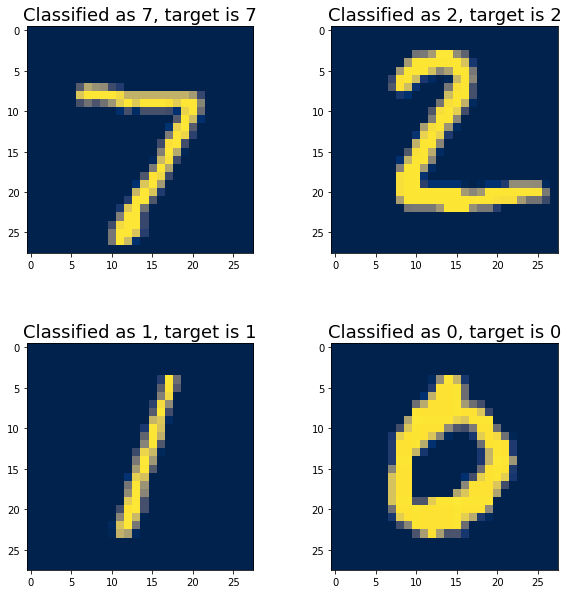

In [11]:
PlotExamples(correctly_classified_examples, "Correctly_classified")

There is not too much to say about the correctly classified examples. They all seem to be pretty easy to handle for the classifier. As for the misclassified examples, there were some somewhat strange results. As humans, it is hard to understand why the image with the number eight was classified as a five, although one can see the contour of parts of a five if one uses ones imagination. It is also a little bit hard to see how the image with the number three can be classified as a five, but also here it is possible to see how the classifier got it wrong. One can see something resembling the lower part of a five, and it is not a very pretty number three. The two other misclassification examples makes more sense in our opinion, even though it is easy for us as humans to see what they should be.  

In [12]:
def CreateClusters(n_clusters, train_x, train_y):
    time_s = time.time()
    # sorting the data
    n_classes = 10
    tuples = [(train_x[i], train_y[i]) for i in range(len(train_x))]
    tuples = sorted(tuples, key=lambda x: x[1])
    train_x = np.array([t[0] for t in tuples])
    train_y = np.array([t[1] for t in tuples])
    # flatten
    train_x = train_x.flatten().reshape(train_x.shape)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    break_points = [0]
    for i in range(len(train_y)-1):
        if train_y[i] != train_y[i+1]:
            break_points.append(i+1)
    # kmeans.fit(train_x)
    break_points.append(len(train_x)-1)
    
    clusters = np.empty((n_classes, n_clusters, train_x.shape[1]))
    for i in range(n_classes):
        clusters[i] = kmeans.fit(train_x[break_points[i]:break_points[i+1]]).cluster_centers_
    
    clusters = clusters.flatten().reshape(n_classes*n_clusters, train_x.shape[1])
    print(f"time for Clustering: {time.time()-time_s}")
    return clusters

In [13]:
def cnn_test(clusters, test_x, test_y):
    n_classes = 10
    test_x = test_x.flatten().reshape(test_x.shape)
    conf_matrix = np.zeros((n_classes, n_classes)).astype(int)
    errors = 0
    time_s2 = time.time()
    for index, img in enumerate(test_x):
        distances = []
        for cluster in clusters:
             distances.append(distance.euclidean(img, cluster))
        pred = np.argmin(distances) // 64
        conf_matrix[test_y[index], pred] += 1
        if pred != test_y[index]:
            errors += 1
    print(f"time for Predicting: {time.time()-time_s2}")
    print("Error rate: " + str(errors/len(test_y)))
    PlotConfusionMatrix(conf_matrix, "cNN_test_set")    
    
        
    

In [14]:

clusters = CreateClusters(64, MNISK_Dataset.data["training"]["features"], MNISK_Dataset.data["training"]["targets"])    

/home/simon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/simon/.local/lib/python3.10/si

time for Clustering: 106.85298252105713


time for Predicting: 34.08619022369385
Error rate: 0.0461


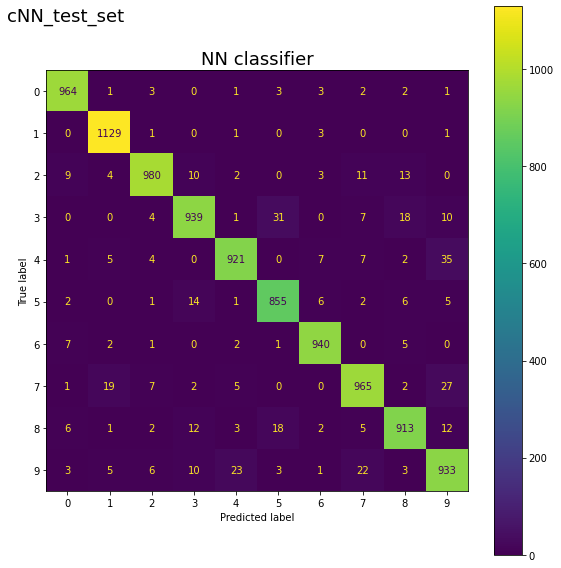

In [15]:
cnn_test(clusters, MNISK_Dataset.data["testing"]["features"], MNISK_Dataset.data["testing"]["targets"])

In [16]:
def cknn_test(clusters, k, test_x, test_y):
    n_classes = 10
    test_x = test_x.flatten().reshape(test_x.shape)
    conf_matrix = np.zeros((n_classes, n_classes)).astype(int)
    errors = 0
    time_s2 = time.time()
    for index, img in enumerate(test_x):
        distances = []
        for cluster in clusters:
             distances.append(distance.euclidean(img, cluster))
    
        top_k = np.argsort(distances)[:k]
        votes = [0] * n_classes
        for val in top_k:
            votes[(val // 64)] += 1
        pred = np.argmax(votes)
        conf_matrix[test_y[index], pred] += 1
        if pred != test_y[index]:
            errors += 1
    print(f"time for Predicting: {time.time()-time_s2}")
    print("Error rate: " + str(errors/len(test_y)))
    PlotConfusionMatrix(conf_matrix, "cKNN_test_set")    

time for Predicting: 34.62937331199646
Error rate: 0.065


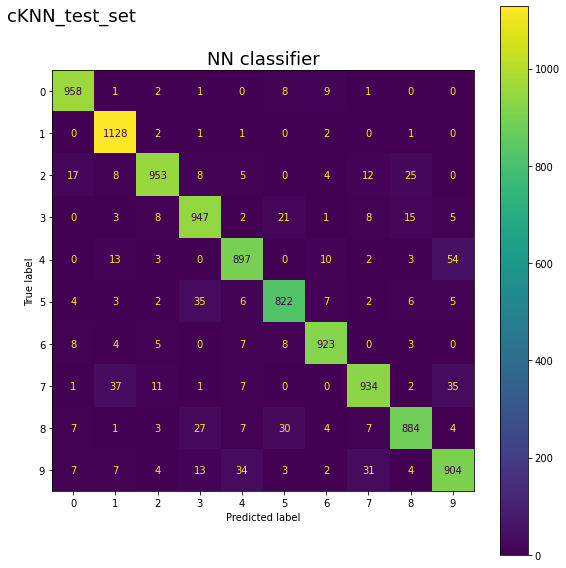

In [17]:
cknn_test(clusters, 7, MNISK_Dataset.data["testing"]["features"], MNISK_Dataset.data["testing"]["targets"])